<a href="https://colab.research.google.com/github/lg550055/MLpremium/blob/main/MLsalary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Let's see if machine learning expertise leads to a salary premium
We'll first import the libraries and the data, which we will then clean

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [104]:
df = pd.read_csv('https://download.data.world/s/3twunbcbeb7bvq5xgb2za5dd3ymzg4')
df.head()

,q1,q4,q5,q6,q8,q15,q20,q24
0,30-34,Master’s degree,Data Engineer,5-10 years,Python,1-2 years,"10,000 or more employees","100,000-124,999"
1,30-34,Master’s degree,Data Scientist,5-10 years,Python,3-4 years,250-999 employees,"125,000-149,999"
2,35-39,Doctoral degree,Research Scientist,1-2 years,R,Under 1 year,0-49 employees,"30,000-39,999"
3,50-54,Master’s degree,Software Engineer,20+ years,Python,1-2 years,50-249 employees,"150,000-199,999"
4,25-29,Master’s degree,Student,1-2 years,Python,1-2 years,NaN,NaN


Clean the data: i. remove q5 and q8 columns and insert meaningful table headings, ii. convert text of columns to numbers, and  iii. eliminate empty (or NaN) entries.

In [105]:
df = df.drop(columns=["q8",'q5'])
df = df.rename(columns={"q1": "age", "q4": "degree", "q6":"codExperience", "q15":"MLexperience", "q20":"coSize", "q24":"salary"})
df.describe()

,age,degree,codExperience,MLexperience,coSize,salary
count,2237,2221,2183,1950,1550,1484
unique,11,7,7,9,5,25
top,30-34,Master’s degree,3-5 years,Under 1 year,"10,000 or more employees","100,000-124,999"
freq,398,1046,509,474,447,249


In [106]:
# exludes ranges under 40k (well below market) and over 300K (few data points / outliers)
mapSalary = {'100,000-124,999':112, '125,000-149,999':132, '150,000-199,999':175, '70,000-79,999':75, '50,000-59,999':55, 
          '250,000-299,999':275, '60,000-69,999':65, '80,000-89,999':85, '40,000-49,999':45, '200,000-249,999':225, '90,000-99,999':95}
df['salary'] = df['salary'].map(mapSalary)

mapCexp = {'5-10 years':7.5, '20+ years':22, '1-2 years':1.5, '10-20 years':15, '3-5 years':4, '< 1 years':0.5}
df['codExperience'] = df['codExperience'].map(mapCexp)

mapMLexp = {'1-2 years':1.5, '3-4 years':3.5, 'Under 1 year':0.5, '5-10 years':7.5, '2-3 years': 2.5, '4-5 years':4.5, '20 or more years':22, '10-20 years':15}
df['MLexperience'] = df['MLexperience'].map(mapMLexp)

# excludes 18-21 b/c seemed to have many non-meaningful datapoints (e.g. coding experience > 20 yrs)
mapAge = {'30-34':32, '50-54':52, '35-39':37, '45-49':47, '25-29':27, '40-44':42, '60-69':64.5, '22-24':23, '55-59':57, '70':70}
df['age'] = df['age'].map(mapAge)

mapDegree = {'Master’s degree':1.5, 'Doctoral degree':2, 'Bachelor’s degree':0.5, 'Some college/university study without earning a bachelor’s degree':0, 'Professional degree':1}
df['degree'] = df['degree'].map(mapDegree)

mapCo = {'10,000 or more employees':2, '250-999 employees':1.5, '50-249 employees':1.25, '0-49 employees':1, '1000-9,999 employees':1.75}
df['coSize'] = df['coSize'].map(mapCo)

In [107]:
# delete rows with non meaningful entries in selected columns
df.dropna(subset=['salary','MLexperience','codExperience','degree','age'], inplace=True)
df.describe()

,age,degree,codExperience,MLexperience,coSize,salary
count,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000
mean,39.786538,1.345192,10.538462,4.272115,1.570673,128.524038
std,11.674982,0.562782,7.423071,4.840327,0.382555,52.535605
min,23.000000,0.000000,0.500000,0.500000,1.000000,45.000000
25%,32.000000,1.000000,4.000000,1.500000,1.250000,95.000000
50%,37.000000,1.500000,7.500000,2.500000,1.750000,112.000000
75%,47.000000,1.500000,15.000000,4.500000,2.000000,175.000000
max,70.000000,2.000000,22.000000,22.000000,2.000000,275.000000


### Plot the data to see if there are readily observable patterns (pairwise scatterplots of all attributes)

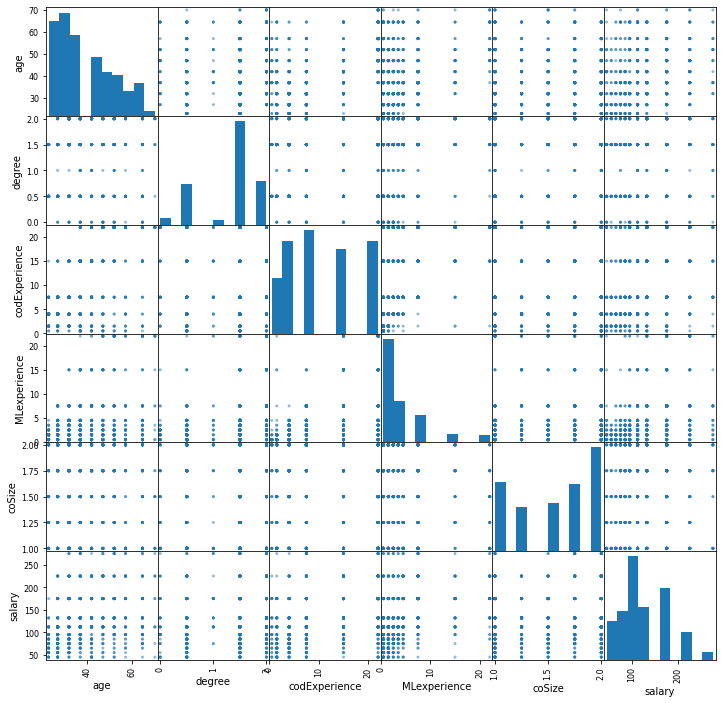

In [108]:
pd.plotting.scatter_matrix(df, figsize=(12,12))
plt.show()

As one would expect, there seems to be a link between salaty and age, albeit not a strong one.

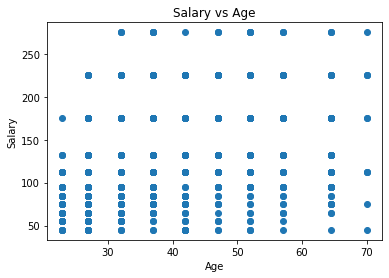

In [109]:
adjData = df.loc[(df['age'] > 20) & (df['salary'] < 300)]
plt.scatter(adjData['age'], adjData['salary'])
plt.title('Salary vs Age')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.show()

#### Let's see if there is a machine learning premium by comparing the salary of programmers with 4 years of experience by years of ML experience

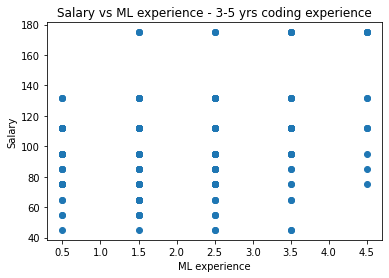

In [110]:
# Excludes salaries > 200k to increase the resolution, without affecting the general conclusion
x4 = df.loc[(df['codExperience'] == 4) & (df['salary'] < 200)]
plt.scatter(x4['MLexperience'],x4['salary'])
plt.title('Salary vs ML experience - 3-5 yrs coding experience')
plt.xlabel('ML experience')
plt.ylabel('Salary')
plt.show()

There also seems to be a slight ML experience salary premium.

Let's see if this is also the case for for programmers with 7.5 years of experience.

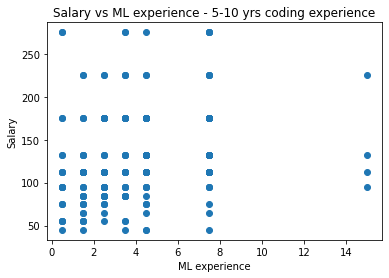

In [111]:
x2 = df.loc[df['codExperience'] == 7.5]
plt.scatter(x2['MLexperience'],x2['salary'])
plt.title('Salary vs ML experience - 5-10 yrs coding experience')
plt.xlabel('ML experience')
plt.ylabel('Salary')
plt.show()

### Let's use a ML model to see if we can better acertain if there is a ML salary premium

In [112]:
# segment data into training and test sets
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)

# split features from labels
train_features = train_data.copy()
test_features = test_data.copy()

train_labels = train_features.pop('salary')
test_labels = test_features.pop('salary')

In [113]:
# Use normalization layer to prevent the scale of the inputs from affecting the gradient and output scale.
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features)

In [114]:
model = tf.keras.Sequential([
  normalizer,
  tf.keras.layers.Dense(1)
])

In [115]:
# Use mean_absolute_error to lower sensitivity to outliers
model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(0.4))

In [127]:
history = model.fit(train_features, train_labels, epochs=25, validation_split = 0.2)

Epoch 1/25
21/21 [==============================] - 0s 14ms/step - loss: 39.5850 - val_loss: 37.0955
Epoch 2/25
21/21 [==============================] - 0s 6ms/step - loss: 38.9736 - val_loss: 36.7340
Epoch 3/25
21/21 [==============================] - 0s 5ms/step - loss: 38.5554 - val_loss: 36.3461
Epoch 4/25
21/21 [==============================] - 0s 6ms/step - loss: 38.2047 - val_loss: 36.4061
Epoch 5/25
21/21 [==============================] - 0s 16ms/step - loss: 38.0287 - val_loss: 36.2073
Epoch 6/25
21/21 [==============================] - 0s 19ms/step - loss: 37.9177 - val_loss: 36.4626
Epoch 7/25
21/21 [==============================] - 0s 8ms/step - loss: 37.7980 - val_loss: 36.1928
Epoch 8/25
21/21 [==============================] - 0s 4ms/step - loss: 37.6841 - val_loss: 36.2309
Epoch 9/25
21/21 [==============================] - 0s 5ms/step - loss: 37.6747 - val_loss: 36.2251
Epoch 10/25
21/21 [==============================] - 0s 5ms/step - loss: 37.6031 - val_loss: 36.3

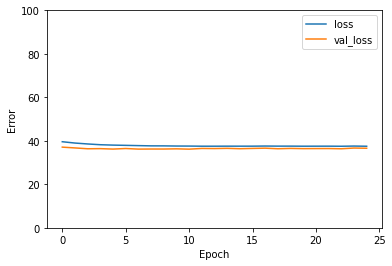

In [128]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [118]:
model.layers[1].kernel

<tf.Variable 'dense_12/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[ 1.7231433],
       [ 2.4748468],
       [13.923374 ],
       [12.544789 ],
       [ 4.674265 ]], dtype=float32)>

In [119]:
model.evaluate(test_features, test_labels, verbose=0)

36.50413513183594

Let's see if we get improvement from using a additional layers

In [120]:
dnn_model = tf.keras.Sequential([
  normalizer,
  tf.keras.layers.Dense(5),
  tf.keras.layers.Dense(5),
  tf.keras.layers.Dense(1)
])

In [121]:
dnn_model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(0.1))

In [122]:
dnn_history = dnn_model.fit(train_features, train_labels, epochs=5, validation_split = 0.2)

Epoch 1/5
21/21 [==============================] - 1s 14ms/step - loss: 99.9746 - val_loss: 48.8880
Epoch 2/5
21/21 [==============================] - 0s 4ms/step - loss: 41.0830 - val_loss: 36.2722
Epoch 3/5
21/21 [==============================] - 0s 6ms/step - loss: 39.4482 - val_loss: 37.7579
Epoch 4/5
21/21 [==============================] - 0s 5ms/step - loss: 38.6808 - val_loss: 38.4543
Epoch 5/5
21/21 [==============================] - 0s 5ms/step - loss: 38.4138 - val_loss: 35.7519


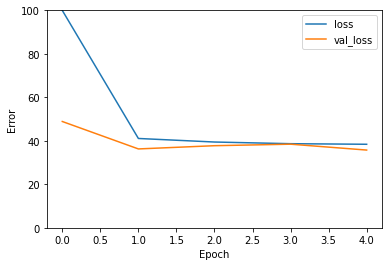

In [123]:
plt.plot(dnn_history.history['loss'], label='loss')
plt.plot(dnn_history.history['val_loss'], label='val_loss')
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [124]:
dnn_model.layers[3].kernel

<tf.Variable 'dense_15/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[ 1.4219935],
       [-1.560762 ],
       [ 1.6580012],
       [ 1.3157018],
       [ 1.8757355]], dtype=float32)>

In [125]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

35.05939483642578

#### Predictions
Since there does not seem to be a significant difference between the one-layer model and the three-layer, we'll use the one-layer to make predictions on the test set

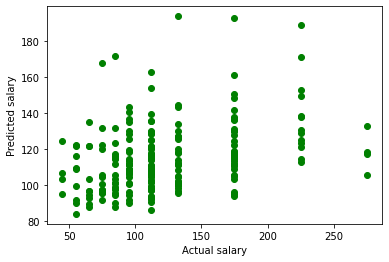

In [126]:
predictions = dnn_model.predict(test_features)
plt.scatter(test_labels, predictions, c='green')
plt.xlabel('Actual salary')
plt.ylabel('Predicted salary')
#plt.xlim([0, 200])
#plt.ylim([50, 250])
plt.show()

### Conclusion: The dataset makes it hard to draw definitive conclusions.  However, there seems to be a sligh premium to ML expertise
